In [135]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix


In [136]:
df = pd.read_csv("/content/upi_raw_data.csv")


In [137]:
df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Transaction ID   1000 non-null   object 
 1   Timestamp        1000 non-null   object 
 2   Sender Name      1000 non-null   object 
 3   Sender UPI ID    1000 non-null   object 
 4   Receiver Name    1000 non-null   object 
 5   Receiver UPI ID  1000 non-null   object 
 6   Amount (INR)     1000 non-null   float64
 7   Status           1000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 62.6+ KB


,0
Transaction ID,0
Timestamp,0
Sender Name,0
Sender UPI ID,0
Receiver Name,0
Receiver UPI ID,0
Amount (INR),0
Status,0


In [138]:
df.duplicated(subset="Transaction ID").sum()


np.int64(0)

In [139]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])


/tmp/ipython-input-858413936.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"])


In [140]:
df["Date"] = df["Timestamp"].dt.date
df["Time"] = df["Timestamp"].dt.time


In [141]:
df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.day
df["Month"] = df["Timestamp"].dt.month
df["Weekday"] = df["Timestamp"].dt.day_name()


In [142]:
merchant_handles = ["@okbiz", "@paytm", "@apl", "@ybl"]

df["Transaction_Type"] = np.where(
    df["Receiver UPI ID"].str.contains("|".join(merchant_handles), case=False, na=False),
    "P2M",
    "P2P"
)


In [143]:
def extract_app(upi_id):
    if pd.isna(upi_id):
        return "Unknown"
    upi_id = upi_id.lower()
    if "@okaxis" in upi_id or "@okhdfc" in upi_id:
        return "Google Pay"
    elif "@ybl" in upi_id:
        return "PhonePe"
    elif "@paytm" in upi_id:
        return "Paytm"
    else:
        return "Other"

df["App"] = df["Sender UPI ID"].apply(extract_app)


In [144]:
def extract_bank(upi_id):
    if pd.isna(upi_id):
        return "Unknown"
    upi_id = upi_id.lower()
    if "okhdfc" in upi_id:
        return "HDFC Bank"
    elif "okaxis" in upi_id:
        return "Axis Bank"
    elif "ybl" in upi_id:
        return "Yes Bank"
    elif "oksbi" in upi_id:
        return "SBI Bank"
    else:
        return "Other Bank"

df["Sender_Bank"] = df["Sender UPI ID"].apply(extract_bank)


In [145]:
df["Failed_Flag"] = np.where(df["Status"].str.lower() == "failed", 1, 0)
df["Success_Flag"] = np.where(df["Status"].str.lower() == "success", 1, 0)


In [146]:
total_transactions = df.shape[0]


In [147]:
total_amount = df["Amount (INR)"].sum()


In [148]:
status_summary = df["Status"].value_counts(normalize=True) * 100


In [149]:
app_transactions = df["App"].value_counts()


In [150]:
transaction_type_summary = df["Transaction_Type"].value_counts()


In [151]:
hourly_trend = df.groupby("Hour")["Transaction ID"].count()


In [152]:
monthly_trend = df.groupby("Month")["Transaction ID"].count()


In [153]:
df.to_csv("upi_cleaned_data.csv", index=False)


📊 STEP 3: DESCRIPTIVE STATISTICS

In [154]:
df.describe()




,Timestamp,Amount (INR),Hour,Day,Month,Failed_Flag,Success_Flag
count,1000,1000.000000,1000.000000,1000.0,1000.0,1000.000000,1000.000000
mean,2026-02-03 11:59:49.756000,4999.022930,11.504000,3.0,2.0,0.498000,0.502000
min,2026-02-03 00:04:44,28.520000,0.000000,3.0,2.0,0.000000,0.000000
25%,2026-02-03 06:16:22.249999872,2521.620000,6.000000,3.0,2.0,0.000000,0.000000
50%,2026-02-03 12:05:05.500000,4951.435000,12.000000,3.0,2.0,0.000000,1.000000
75%,2026-02-03 17:42:24.249999872,7315.835000,17.000000,3.0,2.0,1.000000,1.000000
max,2026-02-03 23:58:41,9993.060000,23.000000,3.0,2.0,1.000000,1.000000
std,NaN,2873.484534,6.759118,0.0,0.0,0.500246,0.500246


In [155]:
df["Amount (INR)"].skew()
df["Amount (INR)"].kurt()


np.float64(-1.1792492648911042)

TRANSACTION PATTERNS & TRENDS

In [156]:
hourly_count = df.groupby("Hour")["Transaction ID"].count()
hourly_amount = df.groupby("Hour")["Amount (INR)"].sum()
hourly_failure = df.groupby("Hour")["Failed_Flag"].mean() * 100


In [157]:
df.groupby("App")["Failed_Flag"].mean() * 100
df.groupby("Sender_Bank")["Failed_Flag"].mean() * 100


,Failed_Flag
Sender_Bank,
Axis Bank,54.040404
HDFC Bank,52.659574
Other Bank,47.087379
SBI Bank,46.889952
Yes Bank,48.743719


In [158]:
#PREDICTIVE MODELING – FAILURE PREDICTION

In [159]:
df["Target"] = np.where(df["Status"].str.lower() == "success", 1, 0)


In [160]:
features = [
    "Amount (INR)",
    "Hour",
    "DayOfWeek_Num",
    "Transaction_Type",   # needs encoding
    "App",                # needs encoding
    "Sender_Bank"         # needs encoding
]


In [161]:
df["DayOfWeek_Num"] = df["Timestamp"].dt.dayofweek

df_encoded = pd.get_dummies(
    df[features],
    drop_first=True
)
df_encoded.head()

,Amount (INR),Hour,DayOfWeek_Num,App_Other,Sender_Bank_HDFC Bank,Sender_Bank_Other Bank,Sender_Bank_SBI Bank,Sender_Bank_Yes Bank
0,3907.34,4,1,False,False,False,False,False
1,8404.55,6,1,False,False,False,False,False
2,941.88,4,1,True,False,False,False,True
3,8926.00,9,1,False,True,False,False,False
4,2800.55,8,1,True,False,False,False,True


In [162]:
X = df_encoded
y = df["Target"]


In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [164]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [165]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.54
[[53 47]
 [45 55]]
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       100
           1       0.54      0.55      0.54       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200



In [166]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)


In [167]:
feature_importance.head(10)


,Feature,Importance
0,Amount (INR),0.623288
1,Hour,0.324090
4,Sender_Bank_HDFC Bank,0.013389
3,App_Other,0.011211
5,Sender_Bank_Other Bank,0.010098
7,Sender_Bank_Yes Bank,0.009078
6,Sender_Bank_SBI Bank,0.008846
2,DayOfWeek_Num,0.000000


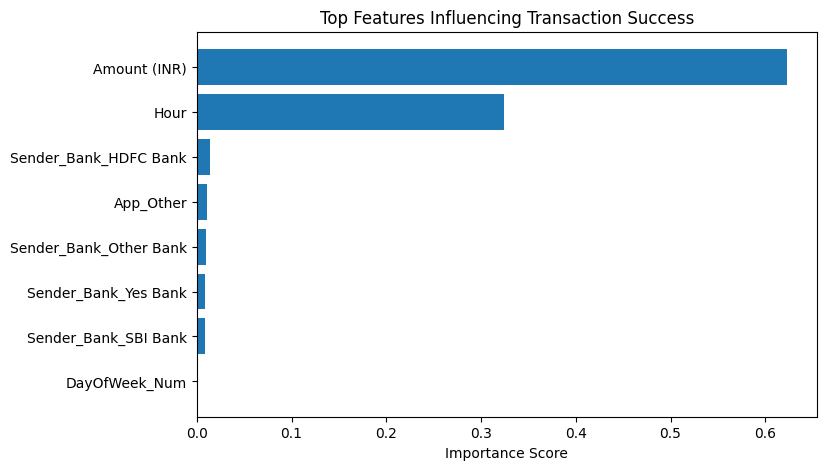

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(
    feature_importance["Feature"][:10],
    feature_importance["Importance"][:10]
)
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top Features Influencing Transaction Success")
plt.show()



In [169]:
#FRAUD DETECTION (Isolation Forest)

In [170]:
anomaly_features = df[[
    "Amount (INR)",
    "Hour"
]]


In [171]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
anomaly_scaled = scaler.fit_transform(anomaly_features)


In [172]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.02,   # 2% anomalies
    random_state=42
)

df["Anomaly"] = iso_forest.fit_predict(anomaly_scaled)


In [173]:
df["Anomaly_Flag"] = df["Anomaly"].map({1: 0, -1: 1})


In [174]:
df["Anomaly_Flag"].value_counts()


,count
Anomaly_Flag,
0,980
1,20


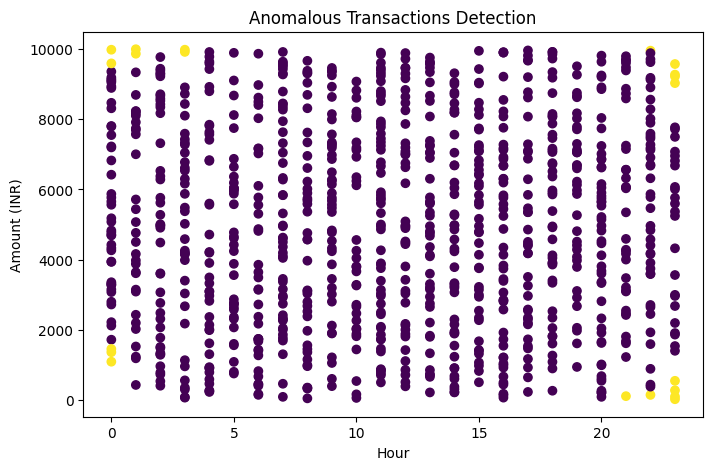

In [175]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(
    df["Hour"],
    df["Amount (INR)"],
    c=df["Anomaly_Flag"]
)
plt.xlabel("Hour")
plt.ylabel("Amount (INR)")
plt.title("Anomalous Transactions Detection")
plt.show()


In [176]:
#CLUSTERING ANALYSIS (PCA + KMEANS)

In [177]:
cluster_features = df[[
    "Amount (INR)",
    "Hour"
]]


In [178]:
scaled_cluster_data = scaler.fit_transform(cluster_features)



In [179]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_cluster_data)


In [180]:
pca.explained_variance_ratio_


array([0.51051421, 0.48948579])

In [181]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(pca_data)


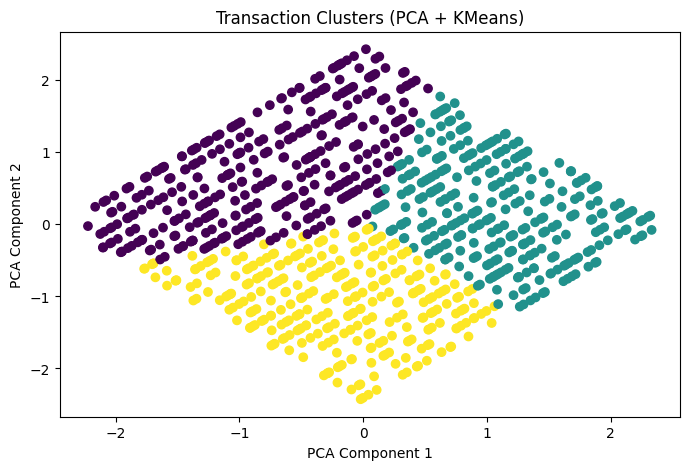

In [182]:
plt.figure(figsize=(8,5))
plt.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    c=df["Cluster"]
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Transaction Clusters (PCA + KMeans)")
plt.show()


In [183]:
df.groupby("Cluster")[["Amount (INR)", "Hour"]].mean()


,Amount (INR),Hour
Cluster,,
0,4893.526528,4.191667
1,7662.537191,15.765432
2,2388.263703,15.465190


FINAL ANALYTICAL SUMMARY


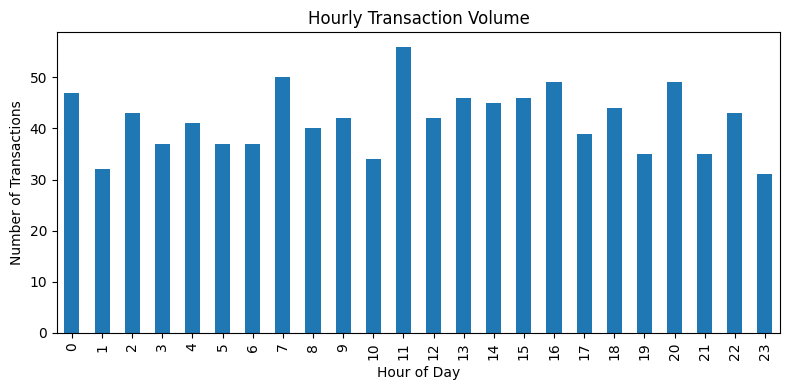

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
df.groupby("Hour")["Transaction ID"].count().plot(kind="bar")
plt.title("Hourly Transaction Volume")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()


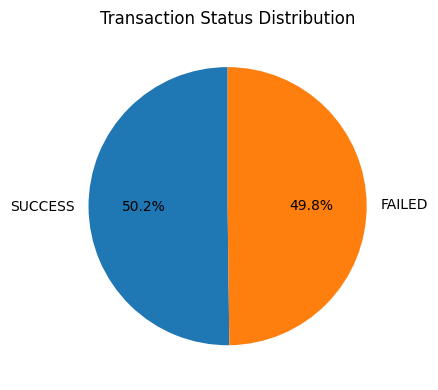

In [185]:
plt.figure(figsize=(5,4))
df["Status"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Transaction Status Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()


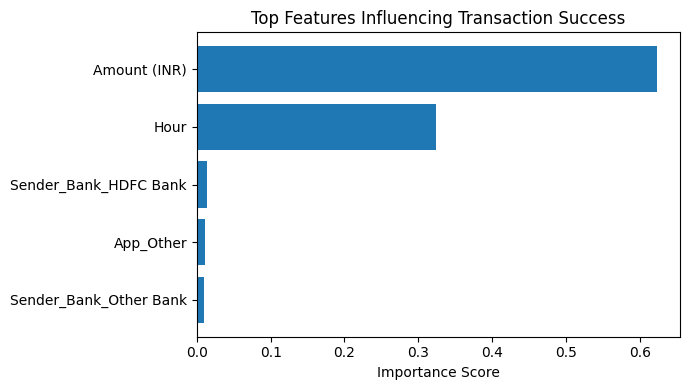

In [186]:
top_features = feature_importance.head(5)

plt.figure(figsize=(7,4))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top Features Influencing Transaction Success")
plt.tight_layout()
plt.show()


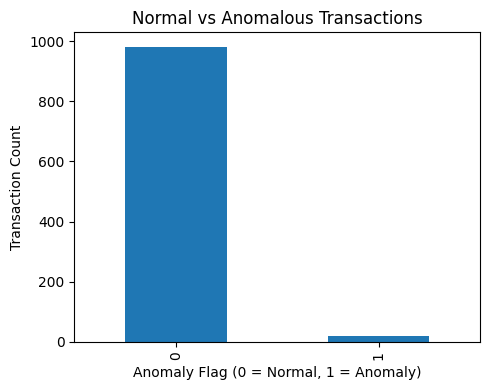

In [187]:
plt.figure(figsize=(5,4))
df["Anomaly_Flag"].value_counts().plot(kind="bar")
plt.title("Normal vs Anomalous Transactions")
plt.xlabel("Anomaly Flag (0 = Normal, 1 = Anomaly)")
plt.ylabel("Transaction Count")
plt.tight_layout()
plt.show()


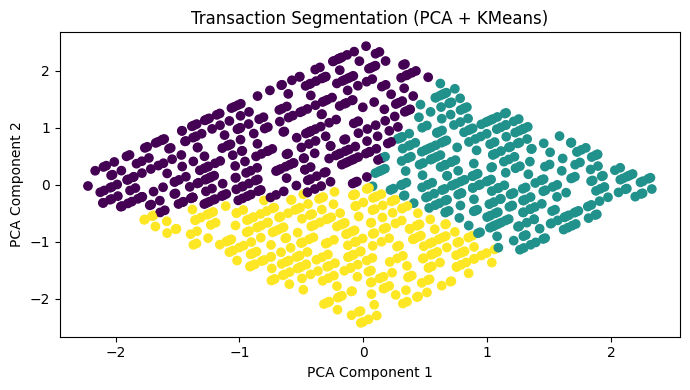

In [188]:
plt.figure(figsize=(7,4))
plt.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    c=df["Cluster"]
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Transaction Segmentation (PCA + KMeans)")
plt.tight_layout()
plt.show()


In [189]:
import sqlite3
import pandas as pd

df = pd.read_csv("upi_cleaned_data.csv")

conn = sqlite3.connect("upi_analysis.db")
df.to_sql("upi_transactions", conn, if_exists="replace", index=False)


1000

In [190]:
query = """
SELECT COUNT(*) AS total_transactions
FROM upi_transactions;
"""

pd.read_sql(query, conn)


,total_transactions
0,1000


In [191]:
query = """
SELECT Status, COUNT(*) AS count
FROM upi_transactions
GROUP BY Status;
"""

pd.read_sql(query, conn)


,Status,count
0,FAILED,498
1,SUCCESS,502


In [192]:
query = """
SELECT Hour, COUNT(*) AS transactions
FROM upi_transactions
GROUP BY Hour
ORDER BY Hour;
"""

pd.read_sql(query, conn)


,Hour,transactions
0,0,47
1,1,32
2,2,43
3,3,37
4,4,41
5,5,37
6,6,37
7,7,50
8,8,40
9,9,42


In [193]:
query = """
SELECT
    App,
    ROUND(AVG(Failed_Flag) * 100, 2) AS failure_rate_pct
FROM upi_transactions
GROUP BY App;
"""

pd.read_sql(query, conn)


,App,failure_rate_pct
0,Google Pay,53.37
1,Other,47.56


In [194]:
query = """
SELECT *
FROM upi_transactions
WHERE "Amount (INR)" > 8000
ORDER BY "Amount (INR)" DESC;
"""

pd.read_sql(query, conn)


,Transaction ID,Timestamp,Sender Name,Sender UPI ID,Receiver Name,Receiver UPI ID,Amount (INR),Status,Date,Time,Hour,Day,Month,Weekday,Transaction_Type,App,Sender_Bank,Failed_Flag,Success_Flag
0,7955e217-102f-41e1-985f-4a3dfb1abaee,2026-02-03 01:20:13,Shlok Loke,8347576235@okicici,Devansh Wagle,1050658519@okaxis,9993.06,SUCCESS,2026-02-03,01:20:13,1,3,2,Tuesday,P2P,Other,Other Bank,0,1
1,81ae109e-2d5b-40c3-8308-c5000cf8b519,2026-02-03 03:14:57,Siya Trivedi,8562122542@okybl,Mishti Chaudry,6315350643@oksbi,9979.32,SUCCESS,2026-02-03,03:14:57,3,3,2,Tuesday,P2P,Other,Yes Bank,0,1
2,bb92963b-f1fc-4b8b-83b1-6c804d38df80,2026-02-03 00:55:03,Taimur Barad,3173202042@okybl,Tarini Shukla,0098135752@oksbi,9978.85,SUCCESS,2026-02-03,00:55:03,0,3,2,Tuesday,P2P,Other,Yes Bank,0,1
3,6b8bd593-9e2d-46f8-9fc7-82e79faeed6c,2026-02-03 17:55:00,Shlok Randhawa,3676327128@okybl,Samar Sawhney,6827243693@okybl,9958.65,SUCCESS,2026-02-03,17:55:00,17,3,2,Tuesday,P2P,Other,Yes Bank,0,1
4,6140dc16-7d90-4ad0-b306-0d13d110f705,2026-02-03 22:31:26,Alisha Kurian,1176434262@oksbi,Tara Dayal,6908948036@oksbi,9952.14,SUCCESS,2026-02-03,22:31:26,22,3,2,Tuesday,P2P,Other,SBI Bank,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,90b95e21-1dae-49f4-8405-06c5240dcc6c,2026-02-03 10:07:23,Divyansh Borah,0435674353@oksbi,Jiya Bath,8834991115@okhdfcbank,8050.72,SUCCESS,2026-02-03,10:07:23,10,3,2,Tuesday,P2P,Other,SBI Bank,0,1
195,a41946ca-5afc-48c7-bcf3-c5a39955cb4d,2026-02-03 20:47:52,Advika Bandi,5103963515@oksbi,Chirag Kaul,2288078376@okaxis,8036.87,SUCCESS,2026-02-03,20:47:52,20,3,2,Tuesday,P2P,Other,SBI Bank,0,1
196,bd8480ab-6843-4625-b894-6dce8e982bcb,2026-02-03 06:32:12,Mishti Wagle,0397647072@okaxis,Ivan Balan,7328545328@oksbi,8027.85,FAILED,2026-02-03,06:32:12,6,3,2,Tuesday,P2P,Google Pay,Axis Bank,1,0
197,b3434da7-0e81-45c3-95f5-1a9a783f25d4,2026-02-03 19:18:05,Saanvi Kumer,1345113433@okaxis,Priyansh Badami,1044579523@okaxis,8021.98,SUCCESS,2026-02-03,19:18:05,19,3,2,Tuesday,P2P,Google Pay,Axis Bank,0,1


In [ ]:
# @title
